# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [13]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [14]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data: same X, three Y outputs

In [15]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [16]:
train_x.shape, train_y.shape

((50,), (50, 3))

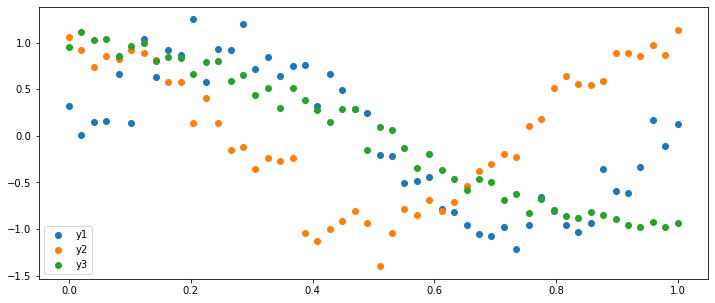

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [18]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [19]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

In [20]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((50, 1), (3, 1), (50, 1))

In [21]:
Xnew = pm.math.cartesian(x, task_i) # For prediction
Xnew.shape

(150, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [22]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over the function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [23]:
# class Kron(Covariance):
#     def __init__(self, factor_list):
#         self.input_dims = [factor.input_dim for factor in factor_list]
#         input_dim = sum(self.input_dims)
#         super().__init__(input_dim=input_dim)
#         self.factor_list = factor_list


#     def __call__(self, X, Xs=None, diag=False):
#         from IPython.core.debugger import set_trace
#         set_trace()
#         covs = [cov(x, None, diag) for cov, x in zip(self.factor_list, X)]
#         return reduce(mul, covs)

In [24]:
# with pm.Model() as model:
#     # Kernel: K_1(x,x')
#     ell = pm.Gamma("ell", alpha=2, beta=0.5)
#     eta = pm.Gamma("eta", alpha=3, beta=1)
#     cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
#     # Coregion B matrix: K_2(o,o')
#     W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
#     kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
#     coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
#     cov_func = pm.gp.cov.Kron([cov, coreg])
#     # Specify the GP.  The default mean function is `Zero`.
#     sigma = pm.HalfNormal("sigma", sigma=3)
#     gp = pm.gp.Marginal(cov_func=cov_func)
#     y_ = gp.marginal_likelihood("f", Xs[0], y.squeeze(), noise=sigma)
    
#     # sigma = pm.HalfNormal("sigma", sigma=3)
#     # # Place a GP prior over the function f.
#     # f = mogp.prior("f", Xs=Xs)
#     # y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [25]:
coreg.full(task_i).eval()

array([[38.76255057, 13.28430314, -8.51190676],
       [13.28430314,  6.3205372 , -6.1835075 ],
       [-8.51190676, -6.1835075 , 14.68491597]])

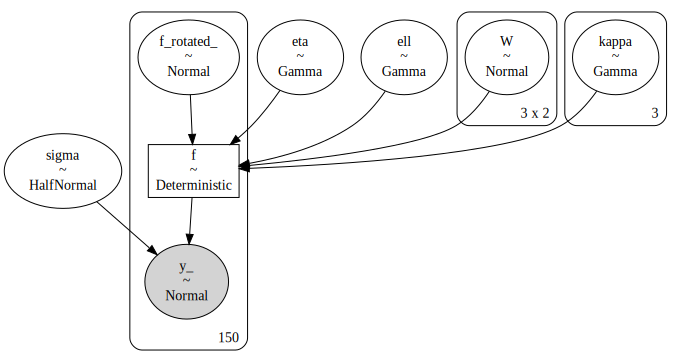

In [26]:
pm.model_to_graphviz(model)

In [27]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 251 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 10min 36s, sys: 22min 23s, total: 33min
Wall time: 4min 33s


#### Prediction

In [28]:
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

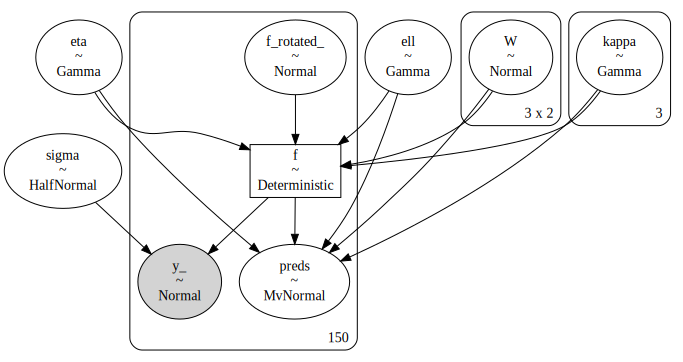

In [29]:
pm.model_to_graphviz(model)

In [30]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 150)

#### Plot the first GP

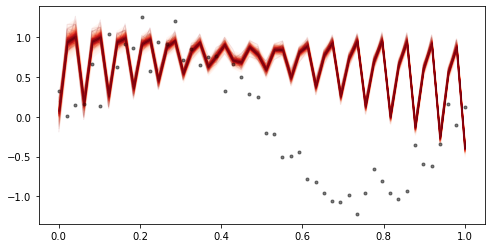

In [31]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:50], x)
plt.show()
# The result seems wrong!

#### Plot the second GP

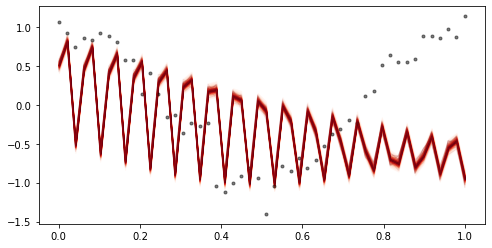

In [32]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 50:100], x)
plt.show()
# The result seems wrong!

### Option2: Implement ICM (one kernel) by using LatentKron with CoregionMatrix

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [33]:
class CoregionMatrix(Covariance):
    r"""
    Coregion Matrix valued covariance function.

    .. math::

       k(x, x') = B(x, x')    """
    
    def __init__(self, W, B):
        super().__init__(1, None)
        self.W = W
        self.B = B

    def diag(self, X):
        return at.alloc(self.B, X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return at.alloc(self.B, X.shape[0], X.shape[0])
        else:
            return at.alloc(self.B, X.shape[0], Xs.shape[0])

#### Create a model

In [34]:
import aesara.tensor as at

with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    B = W @ W.T + kappa
    B = B + at.identity_like(B)
    coreg = CoregionMatrix(W=W,B=B)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over the function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [35]:
coreg.full(task_i).eval()

array([[ 6.17687517, -6.41019903, -2.92487959],
       [-8.23473374, 19.64317104, 11.70590568],
       [-5.07733004, 11.37798995, 10.31240666]])

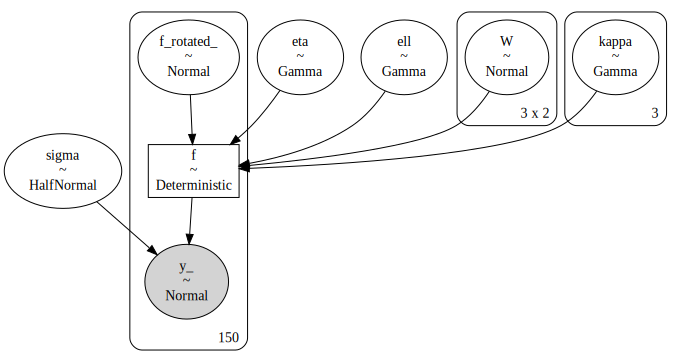

In [36]:
pm.model_to_graphviz(model)

In [37]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 261 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.695, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 10min 59s, sys: 23min 16s, total: 34min 16s
Wall time: 4min 28s


#### Prediction

In [38]:
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

AssertionError: Shapes must be equal
Apply node that caused the error: Assert{msg=Shapes must be equal}(Elemwise{Add}[(0, 1)].0, All.0)
Toposort index: 71
Inputs types: [TensorType(float64, (None, None)), TensorType(bool, ())]
Inputs shapes: [(3, 3), ()]
Inputs strides: [(24, 8), ()]
Inputs values: ['not shown', array(False)]
Outputs clients: [[Elemwise{Composite{(exp((i0 * clip((i1 + i2 + i3), i4, i5))) * i6 * i7)}}[(0, 1)](TensorConstant{(1, 1) of -0.5}, Dot22Scalar.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{x,0}.0, TensorConstant{(1, 1) of 0.0}, TensorConstant{(1, 1) of inf}, Elemwise{sqr,no_inplace}.0, Assert{msg=Shapes must be equal}.0)]]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

#### Plot the first GP

In [ ]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:50], x)
plt.show()
# The result seems wrong!

#### Plot the second GP

In [ ]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 50:100], x)
plt.show()
# The result seems wrong!

In [ ]:
# n_points = 50
# f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
# fig, axes = plt.subplots(3,1, figsize=(8,12))

# for idx in range(3):
#     # plot_gp_dist(axes[idx], f_pred.mean(axis=0)[n_points*idx:n_points*(idx+1)], 
#     #              X_new[n_points*idx:n_points*(idx+1),0], 
#     #              palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
#     axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");
#     axes[idx].plot(x, np.array(f_pred.mean(axis=0)).reshape(-1,1))

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w